In [229]:
%load_ext autoreload
%autoreload 2

import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir) 

import numpy as np
import matplotlib.pyplot as plt

from oed import OED
from oed.utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The forward model used in this notebook is 
$y(\theta,d) = G(\theta,d) + \epsilon = \theta^3 d^2 + \theta \exp(-|0.2-d|) + \epsilon$

Please refer to https://www.sciencedirect.com/science/article/pii/S0021999112004597?casa_token=UsHwNKTdL_MAAAAA:FxO_GF0U9dcFSm137MJl5VZjA3Ruom58zgTCBghK98wa8RvfTexid_789oyVYP_I4hbHW5E for more details.

# One stage, one design variable

In [137]:
def model_1(theta, d):
    """
    Linear model function G(theta, d) = theta * d

    Parameters
    ----------
    stage : int
        The stage index of the experiment.
    theta : np.ndarray of size (n_sample or 1, n_param)
        The value of unknown linear model parameters.
    d : np.ndarray of size (n_sample or 1, n_design)
        The design variable.

    Returns
    -------
    numpy.ndarray of size (n_sample, n_obs)
        The output of the linear model.
    """
    return theta ** 3 * d ** 2 + theta * np.exp(-np.abs(0.2 - d))

In [172]:
n_param = 1 # Number of parameters.
n_design = 1 # Number of design variables.
n_obs = 1 # Number of observations.

low = 0
high = 1
prior_rvs = lambda n_sample: np.random.uniform(low=low,
                                               high=high,
                                               size=(n_sample, n_param))
prior_logpdf = lambda theta: uniform_logpdf(theta,
                                            low=low,
                                            high=high)

design_bounds = [(0, 1),] # lower and upper bounds of design variables.

# Noise if following N(noise_loc, noise_base_scale + noise_ratio_scale * abs(G))
noise_loc = 0
noise_base_scale = 0.01
noise_ratio_scale = 0
noise_info = [(noise_loc, noise_base_scale, noise_ratio_scale),]

# Random state could be eith an integer or None.
random_state = 2021

In [173]:
oed_1 = OED(model_fun=model_1,
            n_param=n_param,
            n_design=n_design,
            n_obs=n_obs,
            prior_rvs=prior_rvs,
            design_bounds=design_bounds,
            noise_info=noise_info,
            prior_logpdf=prior_logpdf,
            reward_fun=None,
            random_state=random_state)

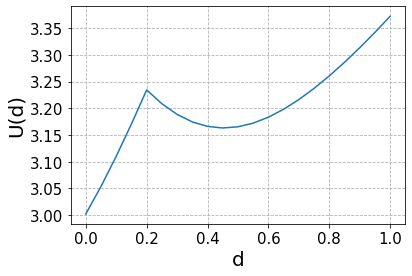

In [174]:
ds = np.linspace(design_bounds[0][0], design_bounds[0][1], 21)
Us = []
thetas = prior_rvs(1000)
noises = np.random.normal(size=(1000, n_obs))
for d in ds:
    Us.append(oed_1.exp_utility(d, thetas, noises))

plt.figure(figsize=(6, 4))
plt.plot(ds, Us)
plt.xlabel('d', fontsize=20)
plt.ylabel('U(d)', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(ls='--')
plt.show()

In [175]:
d_opt, U_opt = oed_1.oed(n_sample=1000, n_init=5, n_iter=30)

Optimizing
|   iter    |  target   |    d1     |
-------------------------------------
|  1        |  3.16     |  0.606    |
|  2        |  3.205    |  0.7334   |
|  3        |  3.128    |  0.1389   |
|  4        |  3.157    |  0.3127   |
|  5        |  3.346    |  0.9972   |
|  6        |  3.348    |  1.0      |
|  7        |  3.348    |  1.0      |
|  8        |  3.348    |  1.0      |
|  9        |  3.348    |  1.0      |
|  10       |  3.348    |  1.0      |
|  11       |  3.348    |  1.0      |
|  12       |  3.348    |  1.0      |
|  13       |  3.348    |  1.0      |
|  14       |  3.348    |  1.0      |
|  15       |  3.348    |  1.0      |
|  16       |  3.348    |  1.0      |
|  17       |  3.348    |  1.0      |
|  18       |  3.348    |  1.0      |
|  19       |  3.348    |  1.0      |
|  20       |  3.348    |  1.0      |
|  21       |  3.348    |  1.0      |
|  22       |  3.348    |  1.0      |
|  23       |  3.348    |  1.0      |
|  24       |  3.348    |  1.0      |
|

In [176]:
print("Optimal design:", d_opt)
print("Maximum expected utility:", U_opt)

Optimal design: [1.]
Maximum expected utility: 3.347830244735249


# One stage, two design variables in a batch

In [178]:
def model_2(theta, d):
    """
    Linear model function G(theta, d) = theta * d

    Parameters
    ----------
    stage : int
        The stage index of the experiment.
    theta : np.ndarray of size (n_sample or 1, n_param)
        The value of unknown linear model parameters.
    d : np.ndarray of size (n_sample or 1, n_design)
        The design variable.

    Returns
    -------
    numpy.ndarray of size (n_sample, n_obs)
        The output of the linear model.
    """
    d1 = d[:, 0:1]
    d2 = d[:, 1:2]
    return np.c_[theta ** 3 * d1 ** 2 + theta * np.exp(-np.abs(0.2 - d1)),
                 theta ** 3 * d2 ** 2 + theta * np.exp(-np.abs(0.2 - d2))]

In [179]:
n_param = 1 # Number of parameters.
n_design = 2 # Number of design variables.
n_obs = 2 # Number of observations.

low = 0
high = 1
prior_rvs = lambda n_sample: np.random.uniform(low=low,
                                               high=high,
                                               size=(n_sample, n_param))
prior_logpdf = lambda theta: uniform_logpdf(theta,
                                            low=low,
                                            high=high)

design_bounds = [(0, 1), (0, 1)] # lower and upper bounds of design variables.

# Noise if following N(noise_loc, noise_base_scale + noise_ratio_scale * abs(G))
noise_loc = 0
noise_base_scale = 0.01
noise_ratio_scale = 0
noise_info = [(noise_loc, noise_base_scale, noise_ratio_scale),
              (noise_loc, noise_base_scale, noise_ratio_scale)]

# Random state could be eith an integer or None.
random_state = 2021

In [190]:
oed_2 = OED(model_fun=model_2,
            n_param=n_param,
            n_design=n_design,
            n_obs=n_obs,
            prior_rvs=prior_rvs,
            design_bounds=design_bounds,
            noise_info=noise_info,
            prior_logpdf=prior_logpdf,
            reward_fun=None,
            random_state=random_state)

In [181]:
ds = np.linspace(design_bounds[0][0], design_bounds[0][1], 21)
dX, dY = np.meshgrid(ds, ds)
Us = np.zeros_like(dX)
thetas = prior_rvs(1000)
noises = np.random.normal(size=(1000, n_obs))
for i in range(21):
    for j in range(21):
        Us[i][j] = oed_2.exp_utility(np.array([dX[i, j], dY[i, j]]), 
                                     thetas, noises)

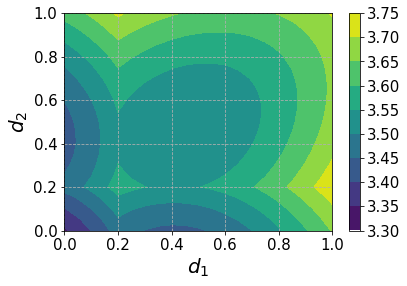

In [186]:
plt.figure(figsize=(6, 4))
plt.contourf(dX, dY, Us)
plt.xlabel('$d_1$', fontsize=20)
plt.ylabel('$d_2$', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(ls='--')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=15)
plt.show()

In [191]:
d_opt, U_opt = oed_2.oed(n_sample=1000, n_init=10, n_iter=30)

Optimizing
|   iter    |  target   |    d1     |    d2     |
-------------------------------------------------
|  1        |  3.543    |  0.606    |  0.7334   |
|  2        |  3.509    |  0.1389   |  0.3127   |
|  3        |  3.702    |  0.9972   |  0.1282   |
|  4        |  3.589    |  0.179    |  0.7529   |
|  5        |  3.563    |  0.6622   |  0.7843   |
|  6        |  3.426    |  0.09689  |  0.05857  |
|  7        |  3.641    |  0.9624   |  0.6166   |
|  8        |  3.484    |  0.08663  |  0.5613   |
|  9        |  3.621    |  0.6165   |  0.9638   |
|  10       |  3.52     |  0.5743   |  0.3712   |
|  11       |  3.619    |  0.0      |  1.0      |
|  12       |  3.704    |  1.0      |  1.0      |
|  13       |  3.654    |  1.0      |  0.0      |
|  14       |  3.688    |  0.2625   |  1.0      |
|  15       |  3.7      |  1.0      |  0.3261   |
|  16       |  3.673    |  0.9989   |  0.8553   |
|  17       |  3.73     |  1.0      |  0.2201   |
|  18       |  3.466    |  0.5991   |  

In [192]:
print("Optimal design:", d_opt)
print("Maximum expected utility:", U_opt)

Optimal design: [0.99997425 0.20116306]
Maximum expected utility: 3.73601414440137


# Two stages in a batch, one design variable in each stage, with a non-KL-divergence reward

In [200]:
def model_3(theta, d):
    """
    Linear model function G(theta, d) = theta * d

    Parameters
    ----------
    stage : int
        The stage index of the experiment.
    theta : np.ndarray of size (n_sample or 1, n_param)
        The value of unknown linear model parameters.
    d : np.ndarray of size (n_sample or 1, n_design)
        The design variable.

    Returns
    -------
    numpy.ndarray of size (n_sample, n_obs)
        The output of the linear model.
    """
    d1 = d[:, 0:1]
    d2 = d[:, 1:2]
    return np.c_[theta ** 3 * d1 ** 2 + theta * np.exp(-np.abs(0.2 - d1)),
                 theta ** 3 * d2 ** 2 + theta * np.exp(-np.abs(0.2 - d2))]

def reward_fun(d, y):
    """
    Non-KL-divergence based reward function.
    
    Parameters
    ----------
    d : np.ndarray of size (n_design)
        The design variable.
    y : np.ndarray of size (n_obs)
        The observation.

    Returns
    -------
    A float which is the reward.
    """
    return -np.abs(d[0])
    

In [201]:
n_param = 1 # Number of parameters.
n_design = 2 # Number of design variables.
n_obs = 2 # Number of observations.

low = 0
high = 1
prior_rvs = lambda n_sample: np.random.uniform(low=low,
                                               high=high,
                                               size=(n_sample, n_param))
prior_logpdf = lambda theta: uniform_logpdf(theta,
                                            low=low,
                                            high=high)

design_bounds = [(0, 1), (0, 1)] # lower and upper bounds of design variables.

# Noise if following N(noise_loc, noise_base_scale + noise_ratio_scale * abs(G))
noise_loc = 0
noise_base_scale = 0.01
noise_ratio_scale = 0
noise_info = [(noise_loc, noise_base_scale, noise_ratio_scale),
              (noise_loc, noise_base_scale, noise_ratio_scale)]

# Random state could be eith an integer or None.
random_state = 2021

In [204]:
oed_3 = OED(model_fun=model_3,
            n_param=n_param,
            n_design=n_design,
            n_obs=n_obs,
            prior_rvs=prior_rvs,
            design_bounds=design_bounds,
            noise_info=noise_info,
            prior_logpdf=prior_logpdf,
            reward_fun=reward_fun,
            random_state=random_state)

In [209]:
ds = np.linspace(design_bounds[0][0], design_bounds[0][1], 21)
dX, dY = np.meshgrid(ds, ds)
Us = np.zeros_like(dX)
thetas = prior_rvs(1000)
noises = np.random.normal(size=(1000, n_obs))
for i in range(21):
    for j in range(21):
        Us[i][j] = oed_3.exp_utility(np.array([dX[i, j], dY[i, j]]), 
                                     thetas, noises)

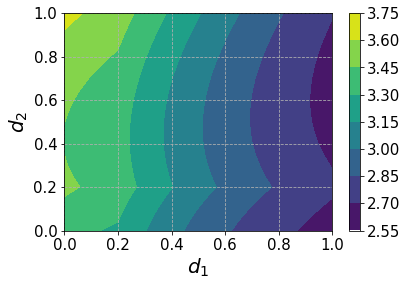

In [210]:
plt.figure(figsize=(6, 4))
plt.contourf(dX, dY, Us)
plt.xlabel('$d_1$', fontsize=20)
plt.ylabel('$d_2$', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(ls='--')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=15)
plt.show()

In [207]:
d_opt, U_opt = oed_3.oed(n_sample=1000, n_init=10, n_iter=30)

Optimizing
|   iter    |  target   |    d1     |    d2     |
-------------------------------------------------
|  1        |  2.951    |  0.606    |  0.7334   |
|  2        |  3.371    |  0.1389   |  0.3127   |
|  3        |  2.69     |  0.9972   |  0.1282   |
|  4        |  3.422    |  0.179    |  0.7529   |
|  5        |  2.915    |  0.6622   |  0.7843   |
|  6        |  3.323    |  0.09689  |  0.05857  |
|  7        |  2.676    |  0.9624   |  0.6166   |
|  8        |  3.407    |  0.08663  |  0.5613   |
|  9        |  3.026    |  0.6165   |  0.9638   |
|  10       |  2.946    |  0.5743   |  0.3712   |
|  11       |  3.644    |  0.0      |  1.0      |
|  12       |  3.616    |  0.0      |  0.9503   |
|  13       |  3.614    |  0.04533  |  0.9994   |
|  14       |  3.614    |  0.04533  |  0.9994   |
|  15       |  3.614    |  0.04533  |  0.9994   |
|  16       |  3.614    |  0.04533  |  0.9994   |
|  17       |  3.614    |  0.04533  |  0.9994   |
|  18       |  3.614    |  0.04533  |  

In [208]:
print("Optimal design:", d_opt)
print("Maximum expected utility:", U_opt)

Optimal design: [0. 1.]
Maximum expected utility: 3.644135871983378


# Four stages sequential design, one design variable in each stage

In [211]:
def model_4(theta, d):
    """
    Linear model function G(theta, d) = theta * d

    Parameters
    ----------
    stage : int
        The stage index of the experiment.
    theta : np.ndarray of size (n_sample or 1, n_param)
        The value of unknown linear model parameters.
    d : np.ndarray of size (n_sample or 1, n_design)
        The design variable.

    Returns
    -------
    numpy.ndarray of size (n_sample, n_obs)
        The output of the linear model.
    """
    return theta ** 3 * d ** 2 + theta * np.exp(-np.abs(0.2 - d))

In [250]:
n_param = 1 # Number of parameters.
n_design = 1 # Number of design variables.
n_obs = 1 # Number of observations.

low = 0
high = 1
prior_rvs = lambda n_sample: np.random.uniform(low=low,
                                               high=high,
                                               size=(n_sample, n_param))
prior_logpdf = lambda theta: uniform_logpdf(theta,
                                            low=low,
                                            high=high)

design_bounds = [(0, 1),] # lower and upper bounds of design variables.

# Noise if following N(noise_loc, noise_base_scale + noise_ratio_scale * abs(G))
noise_loc = 0
noise_base_scale = 0.1
noise_ratio_scale = 0
noise_info = [(noise_loc, noise_base_scale, noise_ratio_scale),]

# Random state could be eith an integer or None.
random_state = 2021

In [251]:
# Assume a true theta to generate synthetic observations.
theta_true = np.array([0.3])

## Stage 1

In [252]:
oed_4_1 = OED(model_fun=model_4,
              n_param=n_param,
              n_design=n_design,
              n_obs=n_obs,
              prior_rvs=prior_rvs,
              design_bounds=design_bounds,
              noise_info=noise_info,
              prior_logpdf=prior_logpdf,
              reward_fun=None,
              random_state=random_state)

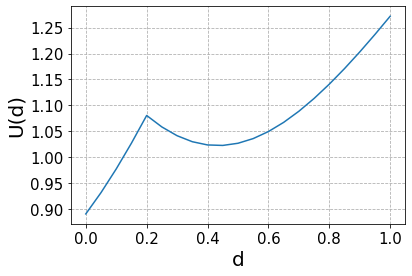

In [253]:
ds = np.linspace(design_bounds[0][0], design_bounds[0][1], 21)
Us = []
thetas = prior_rvs(1000)
noises = np.random.normal(size=(1000, n_obs))
for d in ds:
    Us.append(oed_4_1.exp_utility(d, thetas, noises))

plt.figure(figsize=(6, 4))
plt.plot(ds, Us)
plt.xlabel('d', fontsize=20)
plt.ylabel('U(d)', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(ls='--')
plt.show()

In [254]:
d_opt, U_opt = oed_4_1.oed(n_sample=1000, n_init=5, n_iter=30)

Optimizing
|   iter    |  target   |    d1     |
-------------------------------------
|  1        |  1.046    |  0.606    |
|  2        |  1.094    |  0.7334   |
|  3        |  1.023    |  0.1389   |
|  4        |  1.043    |  0.3127   |
|  5        |  1.248    |  0.9972   |
|  6        |  1.25     |  1.0      |
|  7        |  1.25     |  1.0      |
|  8        |  1.25     |  1.0      |
|  9        |  1.25     |  1.0      |
|  10       |  1.25     |  1.0      |
|  11       |  1.25     |  1.0      |
|  12       |  1.25     |  1.0      |
|  13       |  1.25     |  1.0      |
|  14       |  1.25     |  1.0      |
|  15       |  1.25     |  1.0      |
|  16       |  1.25     |  1.0      |
|  17       |  1.25     |  1.0      |
|  18       |  1.25     |  1.0      |
|  19       |  1.25     |  1.0      |
|  20       |  1.25     |  1.0      |
|  21       |  1.25     |  1.0      |
|  22       |  1.25     |  1.0      |
|  23       |  1.25     |  1.0      |
|  24       |  1.25     |  1.0      |
|

In [255]:
print("Optimal design:", d_opt)
print("Maximum expected utility:", U_opt)

Optimal design: [1.]
Maximum expected utility: 1.2498516411293736


In [256]:
# Conduct an expriment under optimal design and get observation.
# Here we use clean output of forward model as the true experimental result.
y = model_4(theta_true.reshape(1, -1),
            d_opt.reshape(1, -1)).flatten()

/Users/wgshen/Google Drive/PhD/github/OED/oed/utils.py:18: RuntimeWarning: divide by zero encountered in log
  return np.log(uniform_pdf(x, low, high))


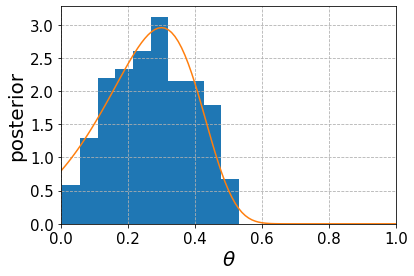

In [266]:
# Generate posterior samples and draw the histogram
theta_post = oed_4_1.post_rvs(1000, d_opt, y)
thetas = np.linspace(0, 1, 101)
posts = oed_4_1.post_pdf(thetas.reshape(-1, 1), d_opt, y)
posts /= posts.sum() * (thetas[1] - thetas[0])

plt.figure(figsize=(6, 4))
plt.hist(theta_post, density=True)
plt.plot(thetas, posts)
plt.xlabel('$\\theta$', fontsize=20)
plt.ylabel('posterior', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(ls='--')
plt.xlim(0, 1)
plt.show()

In [268]:
# Update new prior_rvs and prior_logpdf
prior_rvs = lambda n_sample: oed_4_1.post_rvs(n_sample, d_opt, y)
prior_logpdf = lambda theta: oed_4_1.post_logpdf(theta, d_opt, y)

## Stage 2

In [269]:
oed_4_2 = OED(model_fun=model_4,
              n_param=n_param,
              n_design=n_design,
              n_obs=n_obs,
              prior_rvs=prior_rvs,
              design_bounds=design_bounds,
              noise_info=noise_info,
              prior_logpdf=prior_logpdf,
              reward_fun=None,
              random_state=random_state)

/Users/wgshen/Google Drive/PhD/github/OED/oed/utils.py:18: RuntimeWarning: divide by zero encountered in log
  return np.log(uniform_pdf(x, low, high))


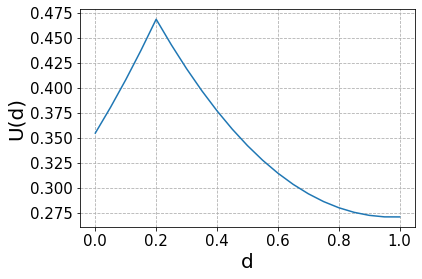

In [270]:
ds = np.linspace(design_bounds[0][0], design_bounds[0][1], 21)
Us = []
thetas = prior_rvs(1000)
noises = np.random.normal(size=(1000, n_obs))
for d in ds:
    Us.append(oed_4_2.exp_utility(d, thetas, noises))

plt.figure(figsize=(6, 4))
plt.plot(ds, Us)
plt.xlabel('d', fontsize=20)
plt.ylabel('U(d)', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(ls='--')
plt.show()

In [271]:
d_opt, U_opt = oed_4_2.oed(n_sample=1000, n_init=5, n_iter=30)

Optimizing


/Users/wgshen/Google Drive/PhD/github/OED/oed/utils.py:18: RuntimeWarning: divide by zero encountered in log
  return np.log(uniform_pdf(x, low, high))


|   iter    |  target   |    d1     |
-------------------------------------
|  1        |  0.3095   |  0.606    |
|  2        |  0.2864   |  0.7334   |
|  3        |  0.4261   |  0.1389   |
|  4        |  0.4086   |  0.3127   |
|  5        |  0.2725   |  0.9972   |
|  6        |  0.3492   |  0.0      |
|  7        |  0.4615   |  0.2055   |
|  8        |  0.4468   |  0.2334   |
|  9        |  0.3531   |  0.4524   |
|  10       |  0.457    |  0.1885   |
|  11       |  0.2732   |  0.8824   |
|  12       |  0.4632   |  0.2022   |
|  13       |  0.462    |  0.2045   |
|  14       |  0.4621   |  0.2044   |
|  15       |  0.4621   |  0.2043   |
|  16       |  0.462    |  0.2045   |
|  17       |  0.4622   |  0.2041   |
|  18       |  0.4621   |  0.2042   |
|  19       |  0.4623   |  0.2039   |
|  20       |  0.4622   |  0.2042   |
|  21       |  0.4624   |  0.2038   |
|  22       |  0.4621   |  0.2042   |
|  23       |  0.4624   |  0.2037   |
|  24       |  0.4626   |  0.2034   |
|  25       

In [272]:
print("Optimal design:", d_opt)
print("Maximum expected utility:", U_opt)

Optimal design: [0.19986129]
Maximum expected utility: 0.4643205387719694


In [273]:
# Conduct an expriment under optimal design and get observation.
# Here we use clean output of forward model as the true experimental result.
y = model_4(theta_true.reshape(1, -1),
            d_opt.reshape(1, -1)).flatten()

/Users/wgshen/Google Drive/PhD/github/OED/oed/utils.py:18: RuntimeWarning: divide by zero encountered in log
  return np.log(uniform_pdf(x, low, high))


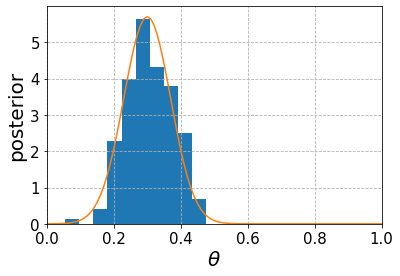

In [274]:
# Generate posterior samples and draw the histogram
theta_post = oed_4_2.post_rvs(1000, d_opt, y)
thetas = np.linspace(0, 1, 101)
posts = oed_4_2.post_pdf(thetas.reshape(-1, 1), d_opt, y)
posts /= posts.sum() * (thetas[1] - thetas[0])

plt.figure(figsize=(6, 4))
plt.hist(theta_post, density=True)
plt.plot(thetas, posts)
plt.xlabel('$\\theta$', fontsize=20)
plt.ylabel('posterior', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(ls='--')
plt.xlim(0, 1)
plt.show()

In [275]:
# Update new prior_rvs and prior_logpdf
prior_rvs = lambda n_sample: oed_4_2.post_rvs(n_sample, d_opt, y)
prior_logpdf = lambda theta: oed_4_2.post_logpdf(theta, d_opt, y)

## Stage 3

In [276]:
oed_4_3 = OED(model_fun=model_4,
              n_param=n_param,
              n_design=n_design,
              n_obs=n_obs,
              prior_rvs=prior_rvs,
              design_bounds=design_bounds,
              noise_info=noise_info,
              prior_logpdf=prior_logpdf,
              reward_fun=None,
              random_state=random_state)

/Users/wgshen/Google Drive/PhD/github/OED/oed/utils.py:18: RuntimeWarning: divide by zero encountered in log
  return np.log(uniform_pdf(x, low, high))


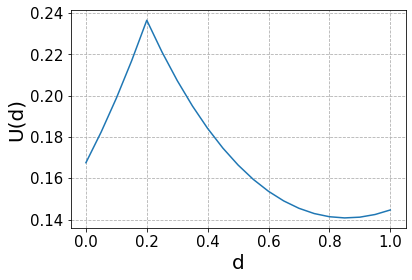

In [277]:
ds = np.linspace(design_bounds[0][0], design_bounds[0][1], 21)
Us = []
thetas = prior_rvs(1000)
noises = np.random.normal(size=(1000, n_obs))
for d in ds:
    Us.append(oed_4_3.exp_utility(d, thetas, noises))

plt.figure(figsize=(6, 4))
plt.plot(ds, Us)
plt.xlabel('d', fontsize=20)
plt.ylabel('U(d)', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(ls='--')
plt.show()

In [278]:
d_opt, U_opt = oed_4_3.oed(n_sample=1000, n_init=5, n_iter=30)

Optimizing


/Users/wgshen/Google Drive/PhD/github/OED/oed/utils.py:18: RuntimeWarning: divide by zero encountered in log
  return np.log(uniform_pdf(x, low, high))


|   iter    |  target   |    d1     |
-------------------------------------
|  1        |  0.1306   |  0.606    |
|  2        |  0.122    |  0.7334   |
|  3        |  0.1842   |  0.1389   |
|  4        |  0.1763   |  0.3127   |
|  5        |  0.1217   |  0.9972   |
|  6        |  0.1443   |  0.0      |
|  7        |  0.2041   |  0.2046   |
|  8        |  0.1963   |  0.2325   |
|  9        |  0.1493   |  0.4538   |
|  10       |  0.1191   |  0.8876   |
|  11       |  0.2027   |  0.1926   |
|  12       |  0.2039   |  0.1958   |
|  13       |  0.204    |  0.1961   |
|  14       |  0.2038   |  0.1956   |
|  15       |  0.2041   |  0.1964   |
|  16       |  0.204    |  0.196    |
|  17       |  0.2043   |  0.1968   |
|  18       |  0.2041   |  0.1963   |
|  19       |  0.204    |  0.1961   |
|  20       |  0.2045   |  0.1973   |
|  21       |  0.2042   |  0.1967   |
|  22       |  0.2034   |  0.1945   |
|  23       |  0.2053   |  0.2006   |
|  24       |  0.205    |  0.2015   |
|  25       

In [279]:
print("Optimal design:", d_opt)
print("Maximum expected utility:", U_opt)

Optimal design: [0.20056345]
Maximum expected utility: 0.20528774421610216


In [280]:
# Conduct an expriment under optimal design and get observation.
# Here we use clean output of forward model as the true experimental result.
y = model_4(theta_true.reshape(1, -1),
            d_opt.reshape(1, -1)).flatten()

/Users/wgshen/Google Drive/PhD/github/OED/oed/utils.py:18: RuntimeWarning: divide by zero encountered in log
  return np.log(uniform_pdf(x, low, high))


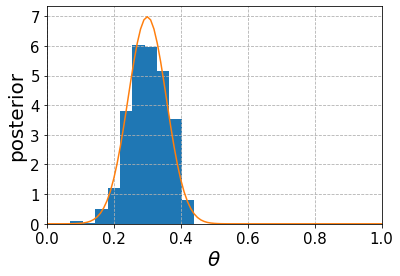

In [281]:
# Generate posterior samples and draw the histogram
theta_post = oed_4_3.post_rvs(1000, d_opt, y)
thetas = np.linspace(0, 1, 101)
posts = oed_4_3.post_pdf(thetas.reshape(-1, 1), d_opt, y)
posts /= posts.sum() * (thetas[1] - thetas[0])

plt.figure(figsize=(6, 4))
plt.hist(theta_post, density=True)
plt.plot(thetas, posts)
plt.xlabel('$\\theta$', fontsize=20)
plt.ylabel('posterior', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(ls='--')
plt.xlim(0, 1)
plt.show()

In [282]:
# Update new prior_rvs and prior_logpdf
prior_rvs = lambda n_sample: oed_4_3.post_rvs(n_sample, d_opt, y)
prior_logpdf = lambda theta: oed_4_3.post_logpdf(theta, d_opt, y)

## Stage 4, with a reward on design and reduced noise scale

In [285]:
def reward_fun(d, y):
    """
    Non-KL-divergence based reward function.
    
    Parameters
    ----------
    d : np.ndarray of size (n_design)
        The design variable.
    y : np.ndarray of size (n_obs)
        The observation.

    Returns
    -------
    A float which is the reward.
    """
    return np.abs(d[0])

noise_loc = 0
noise_base_scale = 0.01
noise_ratio_scale = 0
noise_info = [(noise_loc, noise_base_scale, noise_ratio_scale),]

oed_4_4 = OED(model_fun=model_4,
              n_param=n_param,
              n_design=n_design,
              n_obs=n_obs,
              prior_rvs=prior_rvs,
              design_bounds=design_bounds,
              noise_info=noise_info,
              prior_logpdf=prior_logpdf,
              reward_fun=reward_fun,
              random_state=random_state)

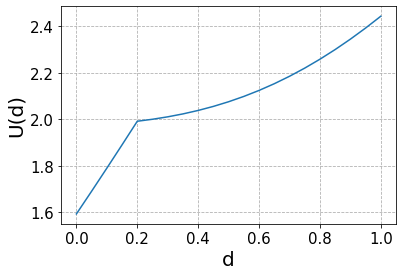

In [287]:
ds = np.linspace(design_bounds[0][0], design_bounds[0][1], 21)
Us = []
thetas = prior_rvs(1000)
noises = np.random.normal(size=(1000, n_obs))
for d in ds:
    Us.append(oed_4_4.exp_utility(np.array([d]), thetas, noises))

plt.figure(figsize=(6, 4))
plt.plot(ds, Us)
plt.xlabel('d', fontsize=20)
plt.ylabel('U(d)', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(ls='--')
plt.show()

In [288]:
d_opt, U_opt = oed_4_4.oed(n_sample=1000, n_init=5, n_iter=30)

Optimizing


/Users/wgshen/Google Drive/PhD/github/OED/oed/utils.py:18: RuntimeWarning: divide by zero encountered in log
  return np.log(uniform_pdf(x, low, high))


|   iter    |  target   |    d1     |
-------------------------------------
|  1        |  2.112    |  0.606    |
|  2        |  2.199    |  0.7334   |
|  3        |  1.839    |  0.1389   |
|  4        |  1.987    |  0.3127   |
|  5        |  2.45     |  0.9972   |
|  6        |  2.453    |  1.0      |
|  7        |  2.453    |  1.0      |
|  8        |  2.453    |  1.0      |
|  9        |  2.453    |  1.0      |
|  10       |  2.453    |  1.0      |
|  11       |  2.453    |  1.0      |
|  12       |  2.453    |  1.0      |
|  13       |  2.453    |  1.0      |
|  14       |  2.453    |  1.0      |
|  15       |  2.453    |  1.0      |
|  16       |  2.453    |  1.0      |
|  17       |  2.453    |  1.0      |
|  18       |  2.453    |  1.0      |
|  19       |  2.453    |  1.0      |
|  20       |  2.453    |  1.0      |
|  21       |  2.453    |  1.0      |
|  22       |  2.453    |  1.0      |
|  23       |  2.453    |  1.0      |
|  24       |  2.453    |  1.0      |
|  25       

In [289]:
print("Optimal design:", d_opt)
print("Maximum expected utility:", U_opt)

Optimal design: [1.]
Maximum expected utility: 2.452891825701876


In [290]:
# Conduct an expriment under optimal design and get observation.
# Here we use clean output of forward model as the true experimental result.
y = model_4(theta_true.reshape(1, -1),
            d_opt.reshape(1, -1)).flatten()

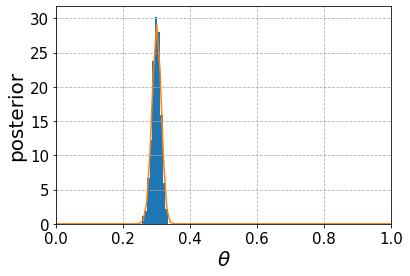

In [291]:
# Generate posterior samples and draw the histogram
theta_post = oed_4_4.post_rvs(1000, d_opt, y)
thetas = np.linspace(0, 1, 101)
posts = oed_4_4.post_pdf(thetas.reshape(-1, 1), d_opt, y)
posts /= posts.sum() * (thetas[1] - thetas[0])

plt.figure(figsize=(6, 4))
plt.hist(theta_post, density=True)
plt.plot(thetas, posts)
plt.xlabel('$\\theta$', fontsize=20)
plt.ylabel('posterior', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(ls='--')
plt.xlim(0, 1)
plt.show()